# LDDMM: influence of control points location

In [1]:
import shutil
from pathlib import Path

import numpy as np
import pyvista as pv
from matplotlib import pyplot as plt

import polpo.lddmm as plddmm
from polpo.mesh.qoi import centroid2farthest_vertex, vertexwise_euclidean
from polpo.mesh.surface import PvSurface
from polpo.mesh.varifold.tuning import SigmaFromLengths
from polpo.plot.pyvista import RegisteredMeshesColoredPlotter
from polpo.preprocessing.load.pregnancy.deformetrica import get_two_random_meshes

[KeOps] Warning : CUDA was detected, but driver API could not be initialized. Switching to CPU only.


In [2]:
RECOMPUTE = False

STATIC_VIZ = True
VIZ = 1

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

In [3]:
STRUCT_NAME = "L_Hipp"


OUTPUTS_DIR = Path.home() / ".polpo/results" / f"lddmm_control_points_{STRUCT_NAME}"
REGISTRATION_DIR = OUTPUTS_DIR / "registration"


if OUTPUTS_DIR.exists() and RECOMPUTE:
    shutil.rmtree(OUTPUTS_DIR)

In [4]:
meshes = get_two_random_meshes(
    OUTPUTS_DIR,
    mesh_names=("source", "target"),
    target_reduction=0,
)

In [5]:
if VIZ > 1:
    pl = pv.Plotter(border=False)

    for mesh in meshes.values():
        pl.add_mesh(mesh.as_pv(), show_edges=True, opacity=0.6)

    pl.show()

We select the varifold kernel [using characteristic lengths](./varifold_kernel_charlen.ipynb).

In [6]:
sigma_search = SigmaFromLengths(
    ratio_charlen_mesh=2.0,
    ratio_charlen=0.25,
)

sigma_search.fit(meshes.values())

metric = sigma_search.optimal_metric_

sigma_search.sigma_

np.float64(5.589180490389398)

Following [LDDMM: how to register a mesh to a template?](./lddmm_register_mesh_template.ipynb).

In [7]:
registration_kwargs = dict(
    kernel_width=4.0,
    regularisation=1.0,
    max_iter=2000,
    freeze_control_points=False,
    metric="varifold",
    tol=1e-16,
    attachment_kernel_width=sigma_search.sigma_,
)

fmt = "%0.6f"
delimiter = " "

registration_dirs = []
mesh_filenames = list(meshes.keys())

In [8]:
registration_dir = REGISTRATION_DIR / "uniform"
registration_dirs.append(registration_dir)


if not registration_dir.exists():
    # ~420 cps
    plddmm.registration.estimate_registration(
        mesh_filenames[0],
        mesh_filenames[1],
        output_dir=registration_dir,
        **registration_kwargs,
    )

Using mesh vertices as control points.

In [9]:
registration_dir = REGISTRATION_DIR / "vertices_full"
registration_dirs.append(registration_dir)


if not registration_dir.exists():
    registration_dir.mkdir(parents=True, exist_ok=True)

    cps_name = registration_dir / "ControlPoints.txt"
    np.savetxt(
        cps_name,
        list(meshes.values())[0].vertices,
        fmt=fmt,
        delimiter=delimiter,
    )

    # ~1002 cps
    plddmm.registration.estimate_registration(
        mesh_filenames[0],
        mesh_filenames[1],
        output_dir=registration_dir,
        initial_control_points=cps_name,
        **registration_kwargs,
    )

Using randomly sampled mesh vertices as control points.

In [10]:
# TODO: use farthest point sampling?
# TODO: use curvature based selection

In [11]:
registration_dir = REGISTRATION_DIR / "vertices_random"
registration_dirs.append(registration_dir)


if not registration_dir.exists():
    registration_dir.mkdir(parents=True, exist_ok=True)

    vertices = list(meshes.values())[0].vertices
    cps_idx = np.random.choice(range(vertices.shape[0]), size=420, replace=False)

    cps_name = registration_dir / "ControlPoints.txt"
    np.savetxt(
        cps_name,
        vertices[cps_idx],
        fmt=fmt,
        delimiter=delimiter,
    )

    # ~420 cps
    plddmm.registration.estimate_registration(
        mesh_filenames[0],
        mesh_filenames[1],
        output_dir=registration_dir,
        initial_control_points=cps_name,
        **registration_kwargs,
    )

## Comparison

In [12]:
reconstructed = {}
cps = {}

for registration_dir in registration_dirs:
    reconstructed[registration_dir.name] = PvSurface(
        plddmm.io.load_deterministic_atlas_reconstruction(registration_dir, as_pv=True)
    )
    cps[registration_dir.name] = plddmm.io.load_cp(registration_dir)

In [13]:
_, target = meshes.values()

{
    name: metric.dist(target, reconstructed_)
    for name, reconstructed_ in reconstructed.items()
}

{'uniform': np.float64(3.8427535440006966),
 'vertices_full': np.float64(3.9352090397352595),
 'vertices_random': np.float64(4.156589211729441)}

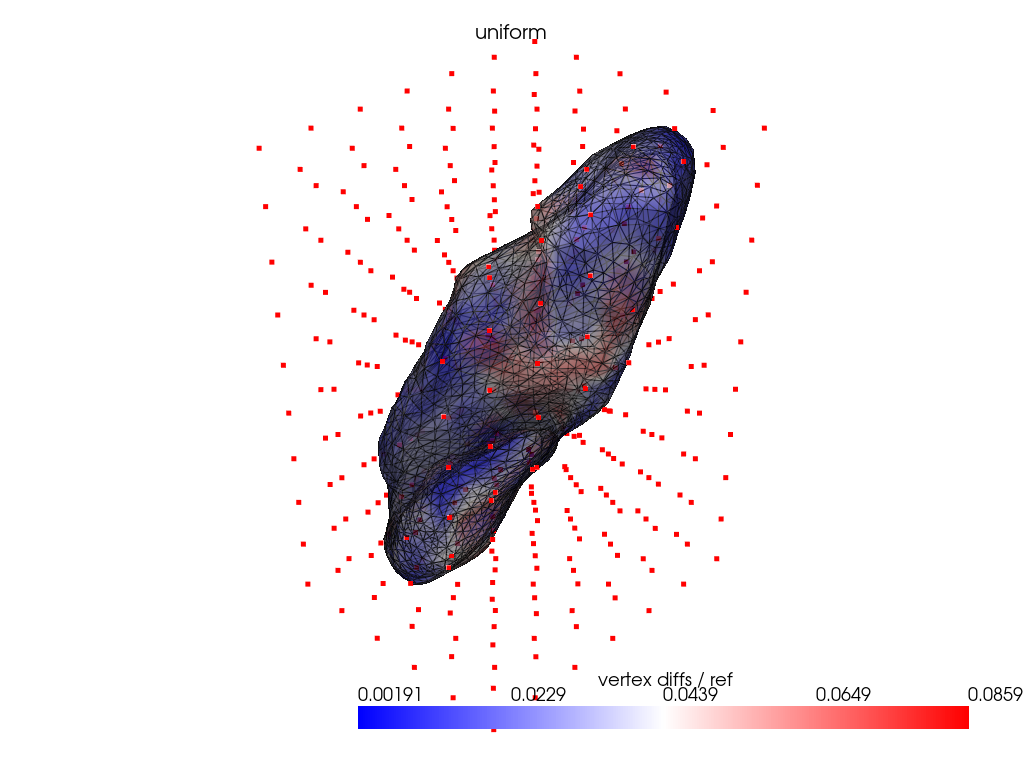

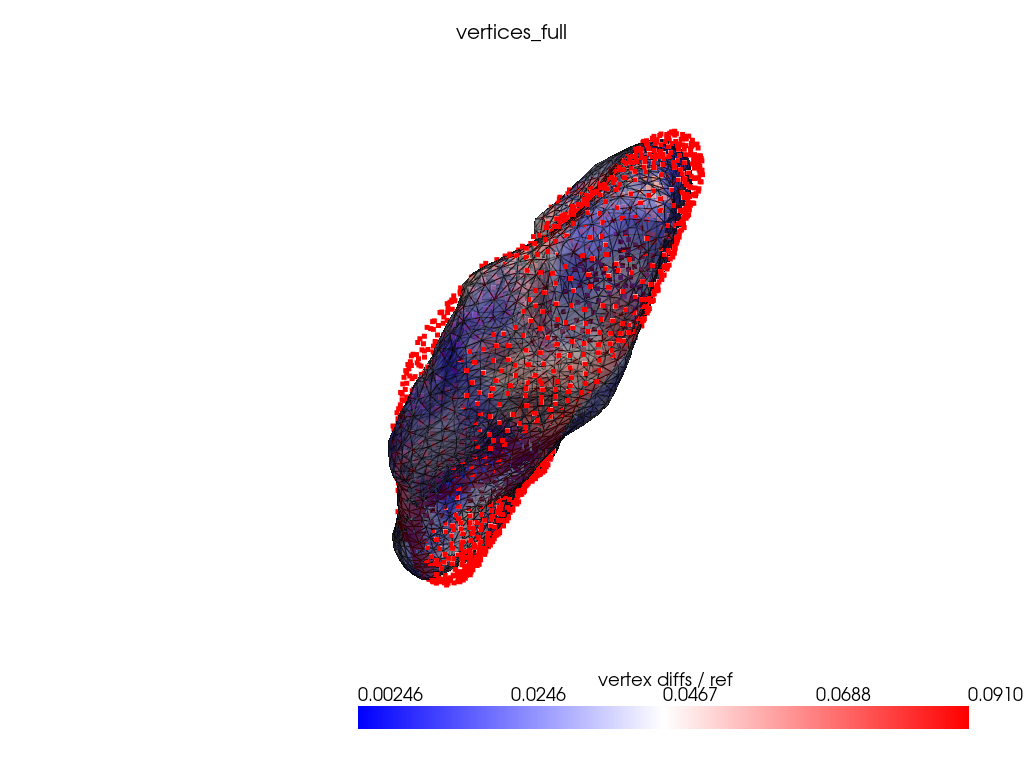

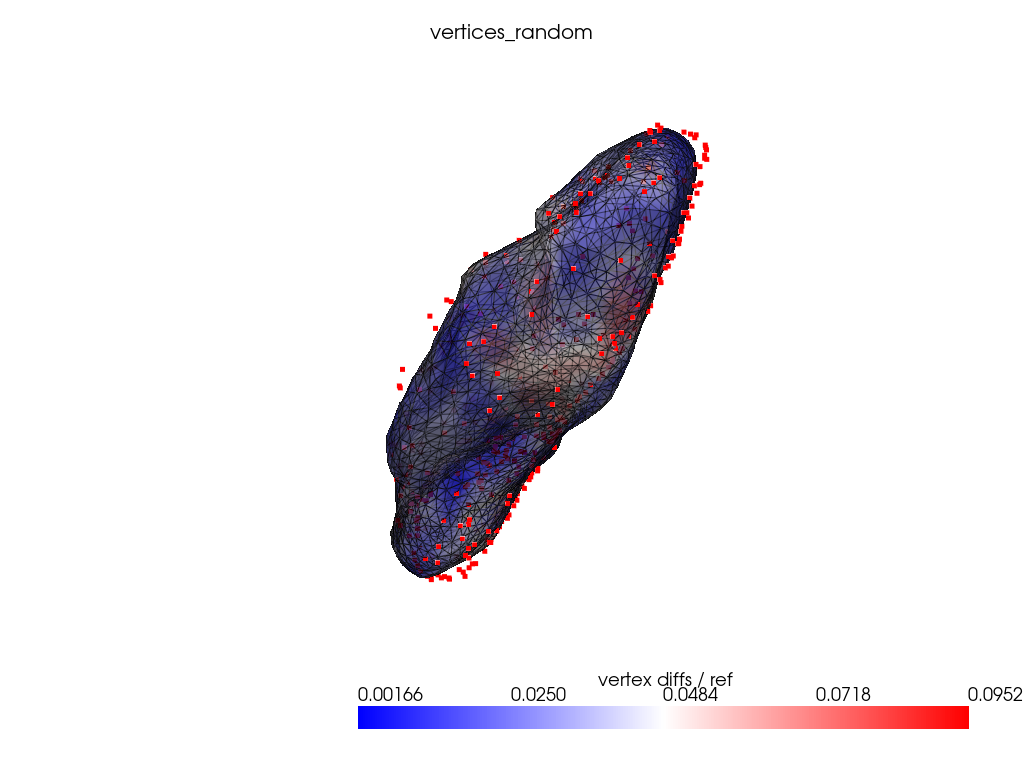

In [14]:
ref_dist = centroid2farthest_vertex([target])[0]

for name, reconstructed_ in reconstructed.items():
    cps_ = cps[name]

    pl = RegisteredMeshesColoredPlotter()

    pl.add_meshes(
        target.as_pv(),
        reconstructed_.as_pv(),
        ref_dist=ref_dist,
        show_edges=True,
        opacity=0.8,
        name="vertex diffs / ref",
    )

    pl.add_title(name, font_size=8.0)

    pl.add_points(pv.PolyData(cps_), color="red")

    pl.show()

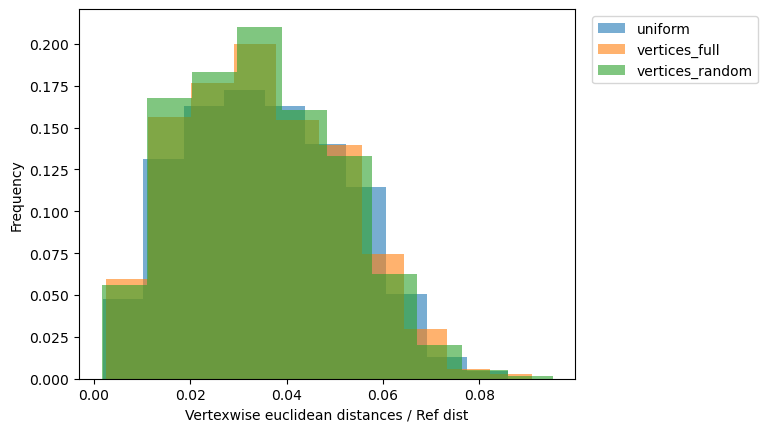

In [15]:
_, ax = plt.subplots()

for name, reconstructed_ in reconstructed.items():
    vals = vertexwise_euclidean(target, reconstructed_) / ref_dist

    ax.hist(
        vals,
        weights=1 / len(vals) * np.ones_like(vals),
        label=name,
        alpha=0.6,
    )

ax.set_xlabel("Vertexwise euclidean distances / Ref dist")
ax.set_ylabel("Frequency")

ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left");

Conclusion: uniform grid is at least as good as other naive control points selection strategy.

# Further reading

* [LDDMM: importance of the data attachment term](./lddmm_data_attachment.ipynb)

* [LDDMM: influence of regularisation](./lddmm_regularisation.ipynb)

* [LDDMM: influence of time points](./lddmm_time_points.ipynb)